In [33]:
#Importing libraries
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
#from keras.datasets import cifar10
from os import listdir
from PIL import Image as PImage
from PIL import ImageOps
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Returns a list of files present in the below directory
folder_path=r'drive/MyDrive/filtered_singlePCBerror/'
imagesList = listdir(folder_path)

In [4]:
# Returns the length of the images list
len(imagesList)

10013

In [5]:
# Define a function which takes the images directory as input and returns 2 lists (list of images & list of image names)
def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        img=ImageOps.grayscale(img)
        img=img.resize((400,400))
        img = np.array(img).astype('float32')
        loadedImages.append(img)

    return loadedImages,imagesList

In [6]:
#call the above function to store the images & image names into 2 seperate lists
folder_path=r'drive/MyDrive/filtered_singlePCBerror/'
images,imagesList = loadImages(folder_path)

In [7]:
# Returns the number of images
len(images)

10013

In [8]:
# Returns the number of image names
len(imagesList)

10013

In [9]:
# Prints the name of the first image
imagesList[0]

'00041126_test-93-217-156-267-1.jpg'

In [10]:
# Load the labels from a csv file into a dataframe
from google.colab import files
import pandas as pd

uploaded = files.upload()
csv_data=pd.read_csv("filtered_singlePCBError_labels.csv")

Saving filtered_singlePCBError_labels.csv to filtered_singlePCBError_labels.csv


In [11]:
# Generates a new csv file with the correct image and class mapping
final_list=[]
len_list=len(imagesList)
for i in range(0,len_list):
  x = csv_data[csv_data["Image_Name"] == imagesList[i]]
  if x is not None:
    index=x.index.astype('int64')
    a=index[0]
    classes=csv_data._get_value(a,'Classes')
    data = [imagesList[i], classes]
    imageName=data[0]
    if imageName[-5]==classes:
      final_list.append(data)
    else:
      classes=imageName[-5]
      data = [imagesList[i], classes]
      final_list.append(data)
    print(data)
    df = pd.DataFrame(final_list,columns =['Image_Name','Classes'])
df.to_csv(r'drive/MyDrive/one_img/PCB_images_labels.csv', index = False)

Streaming output truncated to the last 5000 lines.
['20085176_test-300-90-355-132-5.jpg', '5']
['20085179_test-43-481-80-514-4.jpg', '4']
['20085180_test-257-343-290-370-3.jpg', '3']
['20085177_test-448-515-479-546-3.jpg', '3']
['20085180_test-51-310-86-342-5.jpg', '5']
['20085177_test-301-420-335-454-5.jpg', '5']
['20085200_test-365-456-405-485-1.jpg', '1']
['20085181_test-193-40-227-83-1.jpg', '1']
['20085179_test-397-458-431-545-1.jpg', '1']
['20085177_test-51-489-84-519-6.jpg', '6']
['20085179_test-193-320-230-351-3.jpg', '3']
['20085176_test-473-397-504-426-6.jpg', '6']
['20085176_test-344-231-377-261-5.jpg', '5']
['20085179_test-13-479-51-511-4.jpg', '4']
['20085173_test-377-396-405-423-3.jpg', '3']
['20085173_test-232-440-318-473-1.jpg', '1']
['20085172_test-120-363-153-390-4.jpg', '4']
['20085174_test-127-288-155-314-3.jpg', '3']
['20085173_test-320-273-400-312-1.jpg', '1']
['20085173_test-107-115-141-148-6.jpg', '6']
['20085171_test-323-321-384-362-2.jpg', '2']
['20085171_test

00041126_test-93-217-156-267-1.jpg
['00041126_test-93-217-156-267-1.jpg', '1']


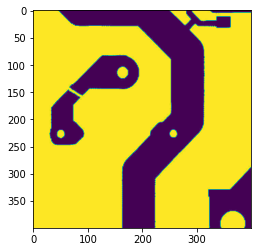

In [12]:
images=np.array(images)
print(imagesList[0])
print(final_list[0])
plt.imshow(images[0])

In [17]:
# load the correct labels from the updated csv file into a dataframe and generates "new_labels (indexed from 0-5)"
from google.colab import files
import pandas as pd

uploaded = files.upload()
labels=pd.read_csv('PCB_images_labels.csv')
labels = labels.pop('Classes')
new_labels = np.array([i-1 for i in labels.values])

Saving PCB_images_labels.csv to PCB_images_labels (2).csv


In [19]:
#Splitting the entire data into train and test data
train_images, x_test, train_labels, y_test = train_test_split(images, new_labels, test_size=0.2, random_state=42)

#splitting the train data(images and labels)to train and validation data
#x_val - validation images
#y_val - validation labels
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=.3)

In [21]:
# Returns the shape of training, validation and test data (images & labels)
print((np.array(x_train).shape,np.array(y_train).shape))
print((np.array(x_val).shape,np.array(y_val).shape))
print((np.array(x_test).shape,np.array(y_test).shape))

((5607, 400, 400), (5607,))
((2403, 400, 400), (2403,))
((2003, 400, 400), (2003,))


In [22]:
#converting the train, test and validation labels to numpy arrays
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [23]:
#Applying data augmentation to the images - random rotations and horizontal flips
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

In [27]:
x_train=np.array(x_train).reshape(5607, 400, 400, 1)
x_val=np.array(x_val).reshape(2403, 400, 400,1)
x_test=np.array(x_test).reshape(2003, 400, 400,1)
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((5607, 400, 400, 1), (5607, 6))
((2403, 400, 400, 1), (2403, 6))
((2003, 400, 400, 1), (2003, 6))


In [28]:
# Converting the images from grayscale to RGB for input to the VGG16 network
x_train=tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_train), name=None)
x_val=tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_val), name=None)
x_test=tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_test), name=None)

In [29]:
# Printing the shape of train, test and validation images
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(5607, 400, 400, 3)
(2403, 400, 400, 3)
(2003, 400, 400, 3)


In [30]:
#Fitting the augmentation to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [32]:
# Get the convolutional base of a VGG16 network pretrained on ImageNet dataset
vgg16_convoltional_base = VGG16(weights='imagenet', include_top=False)
inputlayer=vgg16_convoltional_base.get_layer(index=0)
print(inputlayer)
inputlayer.trainable=False
vgg16_convoltional_base.summary()

# Provide the shape of the input data here - 400x400x3
input = Input(shape=(400, 400, 3))
vgg16_output = vgg16_convoltional_base(input)

# Flatten the output, add FC layers, dropout and output layer
final_output = Flatten(name='flatten')(vgg16_output)
final_output = Dense(512, activation='relu', name='fc1',kernel_regularizer=l2(0.01))(final_output)
final_output = Dense(512, activation='relu', name='fc2',kernel_regularizer=l2(0.01))(final_output)
final_output = Dropout(0.3)(final_output)
final_output = Dense(6, activation='softmax', name='predictions')(final_output)

#Create the model and print the model schematic
my_model = Model(inputs=input, outputs=final_output)
my_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [34]:
# Compiles the model for training
my_model.compile(optimizer=Adam(learning_rate=0.00001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [35]:
#Defining the hyperparameters
batch_size= 20
epochs=50
#learn_rate=.001

In [36]:
#Training the model
history = my_model.fit(train_generator.flow(x_train, y_train, batch_size=batch_size), epochs = epochs, steps_per_epoch = len(x_train)//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size=batch_size), validation_steps = len(x_test)//batch_size, verbose=1)

Epoch 1/50
280/280 [==============================] - 235s 796ms/step - loss: 16.5151 - accuracy: 0.1776 - val_loss: 15.4185 - val_accuracy: 0.1815
Epoch 2/50
280/280 [==============================] - 221s 788ms/step - loss: 14.8428 - accuracy: 0.1971 - val_loss: 14.3341 - val_accuracy: 0.1980
Epoch 3/50
280/280 [==============================] - 221s 790ms/step - loss: 13.9022 - accuracy: 0.2049 - val_loss: 13.5110 - val_accuracy: 0.2000
Epoch 4/50
280/280 [==============================] - 223s 797ms/step - loss: 13.1488 - accuracy: 0.2057 - val_loss: 12.8172 - val_accuracy: 0.1990
Epoch 5/50
280/280 [==============================] - 224s 800ms/step - loss: 12.4434 - accuracy: 0.2549 - val_loss: 12.0241 - val_accuracy: 0.2980
Epoch 6/50
280/280 [==============================] - 222s 792ms/step - loss: 11.6481 - accuracy: 0.3261 - val_loss: 11.2824 - val_accuracy: 0.3590
Epoch 7/50
280/280 [==============================] - 220s 787ms/step - loss: 10.8903 - accuracy: 0.4081 - val_l

In [37]:
#Evaluating the model on the test data
test_loss, test_acc = my_model.evaluate(x_test,  y_test)

63/63 [==============================] - 7s 89ms/step - loss: 1.1071 - accuracy: 0.9516


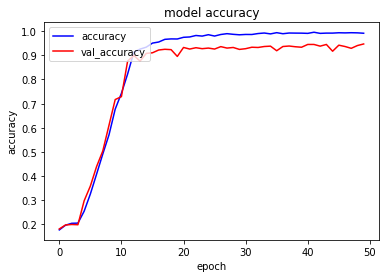

In [38]:
#Plotting the graphs for accuracy and validation_accuracy
plt.plot(history.history['accuracy'],"-b", label="accuracy")
plt.plot(history.history['val_accuracy'],"-r", label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

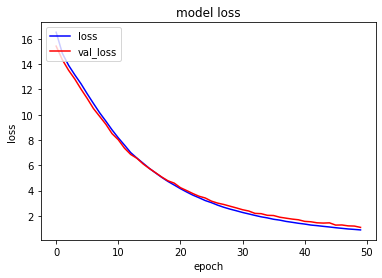

In [39]:
#Plotting the graphs for loss and validation_loss
plt.plot(history.history['loss'],"-b", label="loss")
plt.plot(history.history['val_loss'],"-r", label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [40]:
# Defining the labels
class_names = ['open', 'short', 'mousebite', 'spur', 'copper',
               'pin-hole']

63/63 [==============================] - 5s 73ms/step


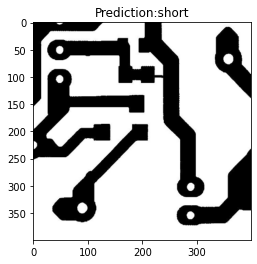

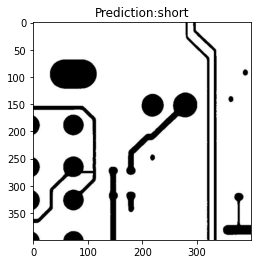

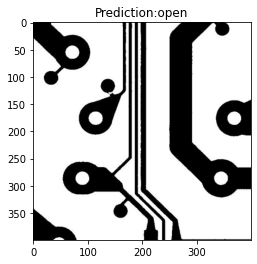

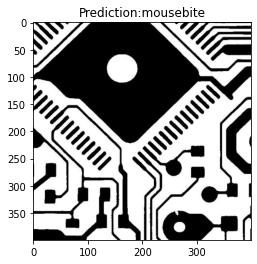

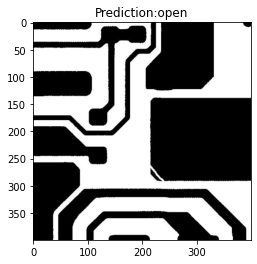

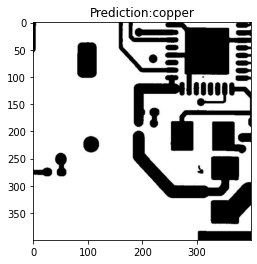

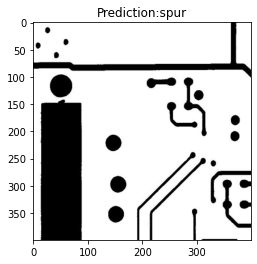

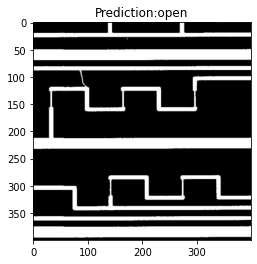

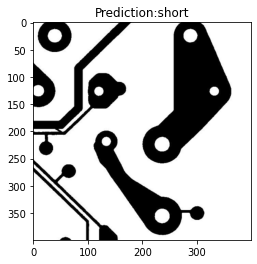

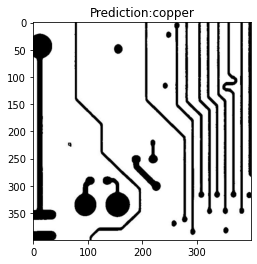

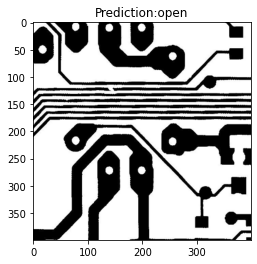

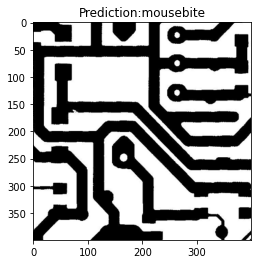

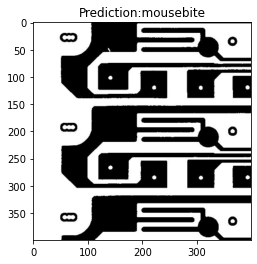

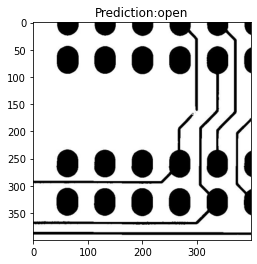

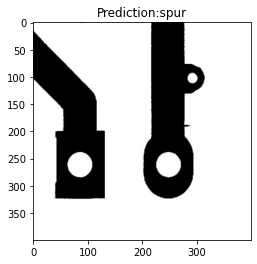

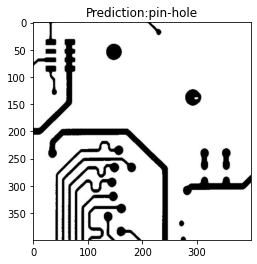

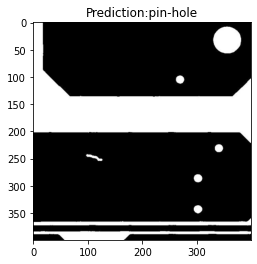

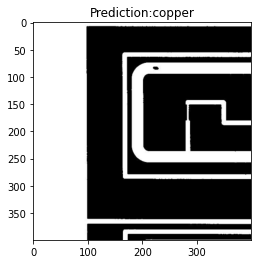

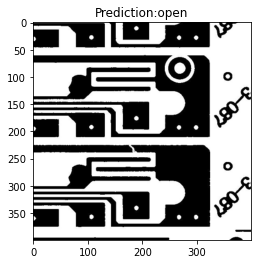

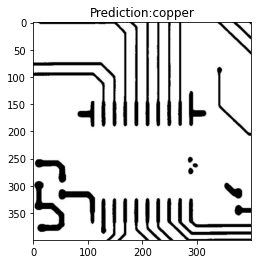

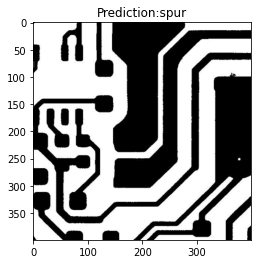

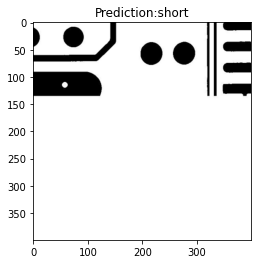

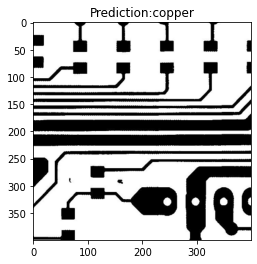

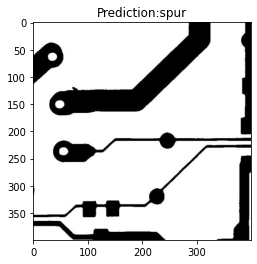

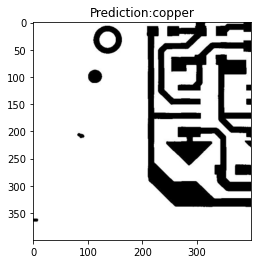

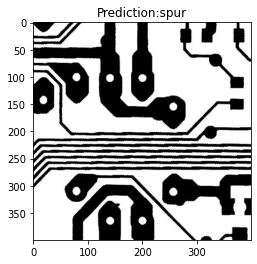

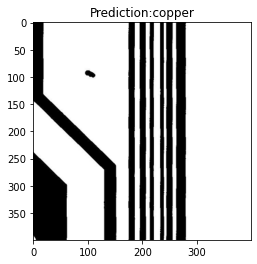

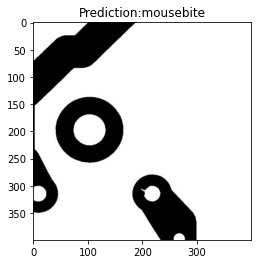

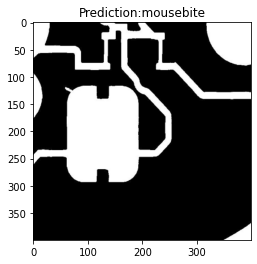

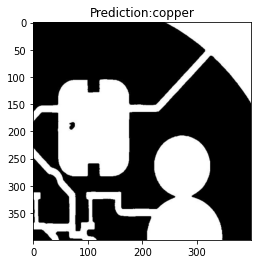

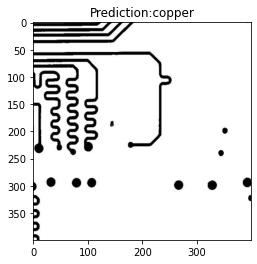

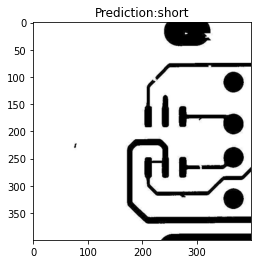

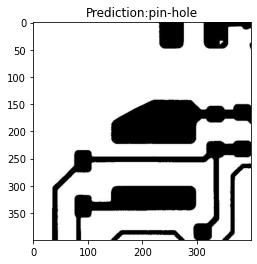

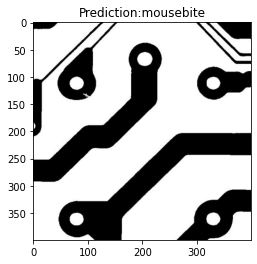

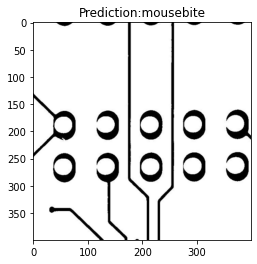

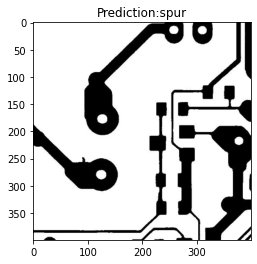

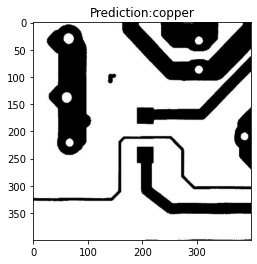

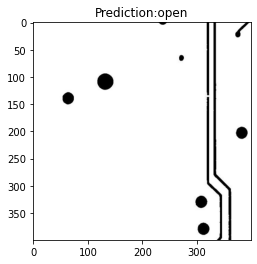

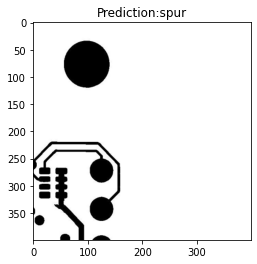

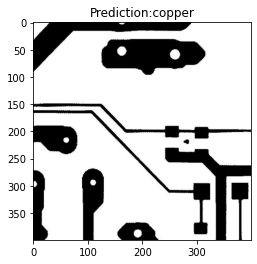

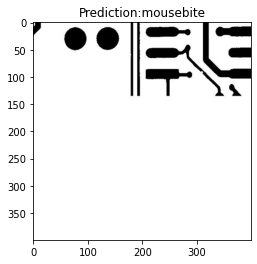

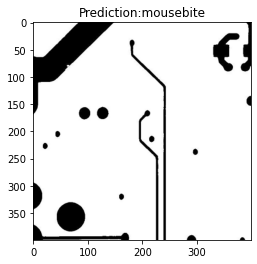

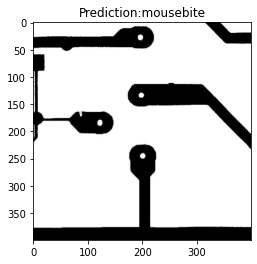

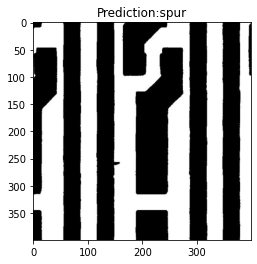

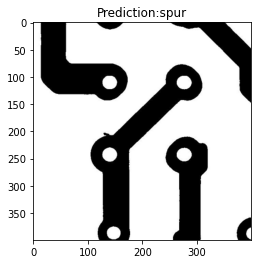

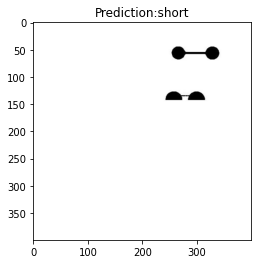

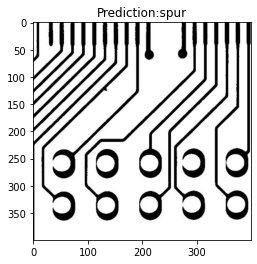

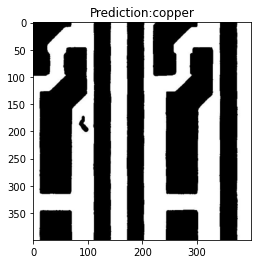

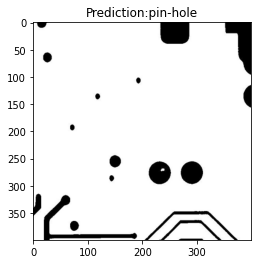

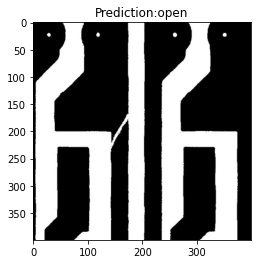

In [65]:
# making predictions

prediction=my_model.predict(x_test)
for i in range(50):
  pil_img = tf.keras.preprocessing.image.array_to_img(x_test[i])
  plt.imshow(pil_img)
  plt.title("Prediction:"+class_names[np.argmax(prediction[i])])
  plt.show()